# Introduction

This notebook focuses on the (1) processing and cleaning of data into usable features and (2) an example of a learning model for predicting daily change in fx.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

The raw data is stored in the following HDF5 file. The data file contains the following dataframes.

In [2]:
store = pd.HDFStore('data/data.hdf5')
store.keys

<bound method HDFStore.keys of <class 'pandas.io.pytables.HDFStore'>
File path: data/data.hdf5
/commodities                frame        (shape->[2635,40])
/fx                         frame        (shape->[3470,8]) 
/indices                    frame        (shape->[2603,36])
/macro_monthly              frame        (shape->[103,4])  
/macro_quarterly            frame        (shape->[36,1])   >

In the initial model, we do not include macroeconomic data first as macro data is monthly/quarterly which is not highly consistent with the purpose of our research our predicting daily fx changes. (p.s. However, in future models, we will try to incorporate macroeconomic data which is appropriately transformed to fit our needs)

In [3]:
com = store.commodities; com.name = 'commodities'
fx = store.fx; fx.name = 'fx'
indices = store.indices; indices.name = 'indices'

# Data Processing

## A Glimpse at Missing Data Problem

Due various unexplained and unexplainable reasons, data may go missing. However, if we filter our entries with no missing rows, then our training set will be very small. Also, it does not make sense to skip certain days in the data because trading goes on regardless of any missing data for any particular trading day. 

We can run through the dataframes to find out the number of missing entries in each feature. This allows us to have an initial decision on whether or not to include this feature in future use.

In [4]:
def glimpseMissingData(df):
    print(df.name)
    for feature in df.columns:
        print(feature, end = " ")
        print("Missing data: %i out of a total of %i entries"%(sum(pd.isnull(df[feature])), df.shape[0]), end = "   ")
        print(sum(pd.isnull(df[feature]))/df.shape[0])
    print()

glimpseMissingData(com)
glimpseMissingData(fx)
glimpseMissingData(indices)

commodities
ODA/PBARL_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
TFGRAIN/CORN.1 Missing data: 126 out of a total of 2635 entries   0.0478178368121
ODA/PRICENPQ_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
TFGRAIN/SOYBEANS.1 Missing data: 126 out of a total of 2635 entries   0.0478178368121
ODA/PWHEAMT_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
CHRIS/ICE_SB1.1 Missing data: 165 out of a total of 2635 entries   0.0626185958254
ODA/PCOFFROB_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
CHRIS/ICE_CT1.1 Missing data: 313 out of a total of 2635 entries   0.118785578748
ODA/PTEA_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
COM/MILK Missing data: 225 out of a total of 2635 entries   0.0853889943074
ODA/PBANSOP_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
ODA/PORANG_USD Missing data: 2515 out of a total of 2635 entries   0.954459203036
OD

It seems like most features have less than 10% missing data. But some data in the `commodities` dataframe has more than 50% missing data. To make things work, we try selecting only features which have less than 10% missing data. 

Furthermore, we only need the adjusted close price and volume from the `indices` dataframe.

In [5]:
def initialFilter(df, cutoff=0.1):
    selected = []
    for feature in df.columns:
        if sum(pd.isnull(df[feature]))/df.shape[0] < cutoff:
            selected.append(feature)
    return df[selected]

com_filtered = initialFilter(com)
fx_filtered = initialFilter(fx)
indices_filtered = initialFilter(indices)

indices_filtered = indices_filtered.filter(regex=".*Adj Close|.*Volume")

Convert `string` to `float` for `indices_filtered`:

In [6]:
def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return np.nan
    
for feature in indices_filtered.columns:
    indices_filtered[feature] = indices_filtered[feature].apply(lambda x: convert_float(x))

## Dealing with Missing Data

To go about this problem, we have decided to use `time` interpolation (to make things simpler) to fill up missing data in the dataframes based on their time intervals. This is on the assumption that there is constant change within the missing time interval.

In [7]:
com_filtered = com_filtered.interpolate(method='time')
fx_filtered = fx_filtered.interpolate(method='time')
indices_filtered = indices_filtered.interpolate(method='time')

Final check on whether is any missing values:

In [8]:
print(sum(com_filtered.isnull().values))
print(sum(fx_filtered.isnull().values))
print(sum(indices_filtered.isnull().values))

[0 0 3 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]


Use backward fill to fill up missing values for the starting 3 entries:

In [9]:
com_filtered = com_filtered.fillna(method='bfill')

In [10]:
print(sum(com_filtered.isnull().values))
print(sum(fx_filtered.isnull().values))
print(sum(indices_filtered.isnull().values))

[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]


### Checking the Indexes

As seen in the previous section, the number of entries in each dataframe varies. We shall take a further look into the indexes on what constitutes the differences.

In [11]:
print(com_filtered.index)
print(fx_filtered.index)
print(indices_filtered.index)

DatetimeIndex(['2007-07-02', '2007-07-03', '2007-07-04', '2007-07-05',
               '2007-07-06', '2007-07-09', '2007-07-10', '2007-07-11',
               '2007-07-12', '2007-07-13',
               ...
               '2017-06-19', '2017-06-20', '2017-06-21', '2017-06-22',
               '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', name='Date', length=2635, freq=None)
DatetimeIndex(['2007-07-01', '2007-07-02', '2007-07-03', '2007-07-04',
               '2007-07-05', '2007-07-06', '2007-07-07', '2007-07-08',
               '2007-07-09', '2007-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='DATE', length=3470, freq=None)
DatetimeIndex(['2007-07-02', '2007-07-03', '2007-07-04', '2007-07-05',

## Joining the Dataframes

Looking at the length of the index arrays, we realize that fx has daily data (24/7 - including weekends ex only a few days) whereas the other 2 dataframes are only recorded based on trading days (daily - usually Monday to Friday ex Public Holidays).

Since we are trading forex, there should be trading done everyday based on the latest information. This gives us a motivation to concatenate the dataframes using the date index of the fx data and apply forward fill to the missing infomation (weekends and public holidays).

As for the missing data for 1 July 2007, we just simply apply backward fill with minimal distortion to the data.

In [12]:
X = pd.concat(objs=[fx_filtered, com_filtered, indices_filtered], axis=1, join_axes=[fx_filtered.index])

X = X.fillna(method='ffill')
X = X.fillna(method='bfill')

### Cleaned Features
Now that the data is cleaned, let's take a look what are the features that remain in our cleaned `X` dataframe.

Index 0 to 7 contain our `target` variable whereas the rest are `predictor` variables like the spot/futures prices of:
- corn
- soybeans
- milk
- gold / silver / platinum / palladium
- oil

and also major stock indices.

In [13]:
pd.Series(X.columns)

0                      CAD
1                      AUD
2                      HKD
3                      EUR
4                      GBP
5                      JPY
6                      MXN
7                      CHF
8           TFGRAIN/CORN.1
9       TFGRAIN/SOYBEANS.1
10         CHRIS/ICE_SB1.1
11                COM/MILK
12              COM/AU_EIB
13              COM/AG_EIB
14              COM/PL_EIB
15              COM/PA_EFP
16          EIA/PET_RWTC_D
17         EIA/PET_RBRTE_D
18                OPEC/ORB
19         CHRIS/CME_NG1.1
20        cac_40_Adj Close
21           cac_40_Volume
22           dax_Adj Close
23              dax_Volume
24     dow_jones_Adj Close
25        dow_jones_Volume
26        nasdaq_Adj Close
27           nasdaq_Volume
28    nikkei_225_Adj Close
29       nikkei_225_Volume
30       s&p_500_Adj Close
31          s&p_500_Volume
dtype: object

### Visualization

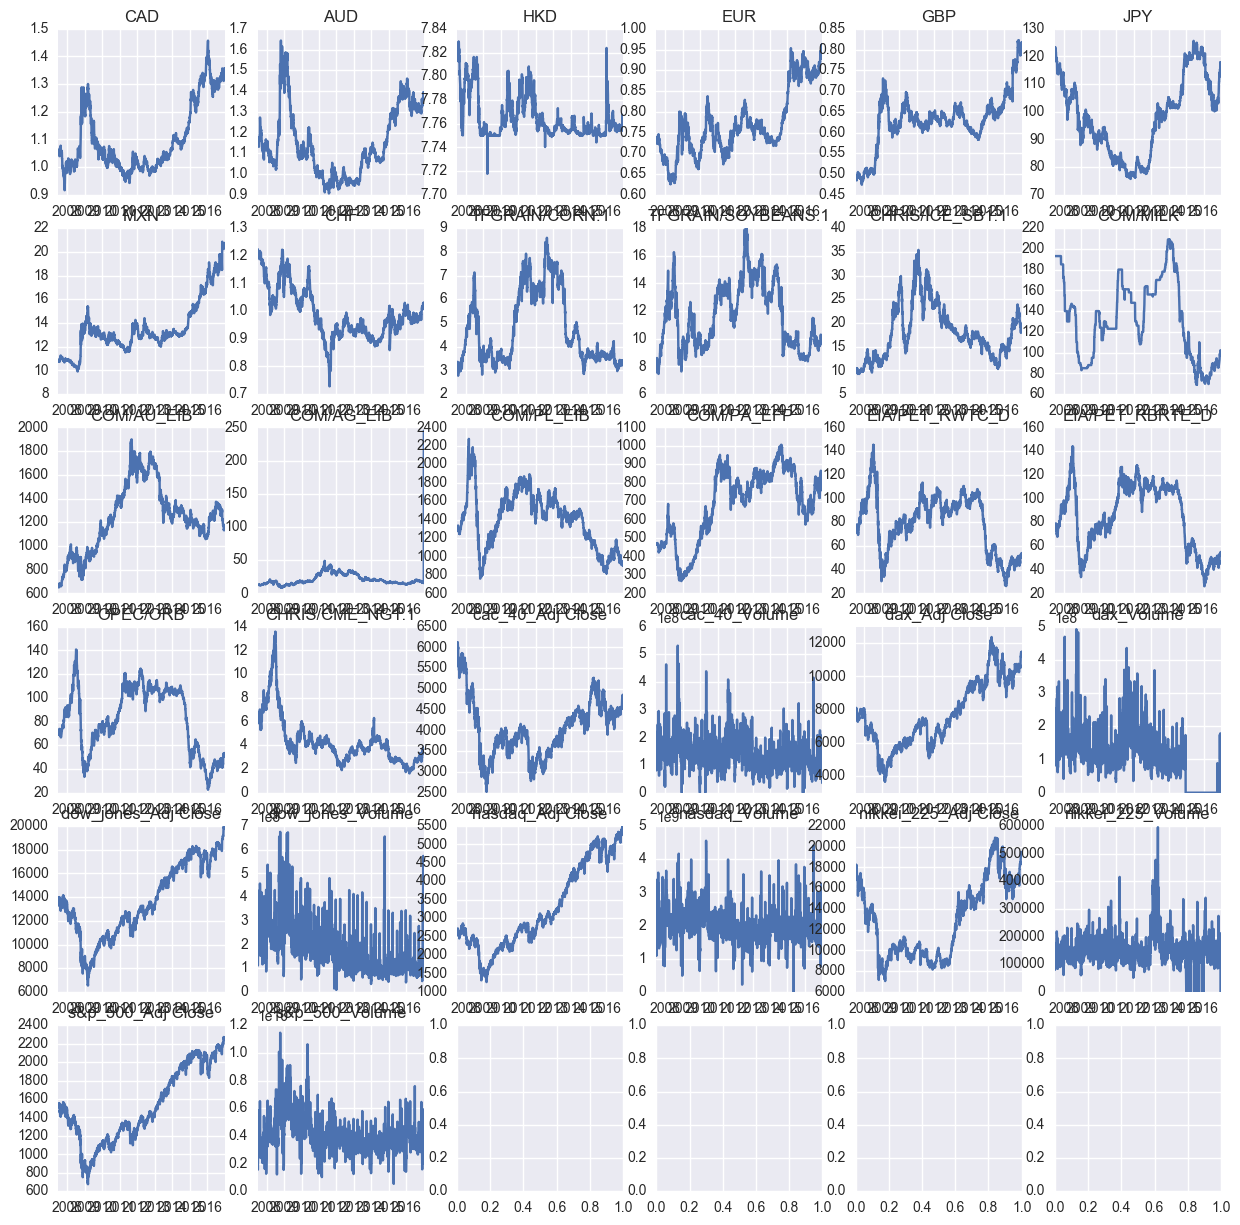

In [14]:
fig, axes = plt.subplots(6, 6, figsize=(15,15))
for i in range(6):
    for j in range(6):
        if (6*i+j > 31):
            pass
        else:
            axes[i, j].plot(X.iloc[:, (6*i+j)])
            axes[i, j].set_title(X.columns[(6*i+j)])
plt.show()

## Convert Absolute Data to Relative Change

As we are predicting the direction and rate of change (daily returns), it is meaningless to use absolute values (close price) of the above features. Only volume data could be used.

We can drop the volume features from the data matrix first, then apply submatrix subtraction and division to get the returns.

In [15]:
temp = X.drop(labels=X.columns[[21, 23, 25, 27, 29, 31]], axis=1).values
returns = (temp[1:,:] - temp[:-1,:])/temp[:-1,:]

Now, our matrix starts from 1 July 2007 to 30 December 2016 as we do not have the data to calculate the returns for 31 December 2016.  (Needs opening price for 1 January 2017!!) Hence, we have to filter out the volume data based on the same date indexes and join with the returns matrix.

In [16]:
volume = X.iloc[:-1, [21, 23, 25, 27, 29, 31]].values
temp = np.concatenate((returns, volume), axis=1)

### Visualization on Returns

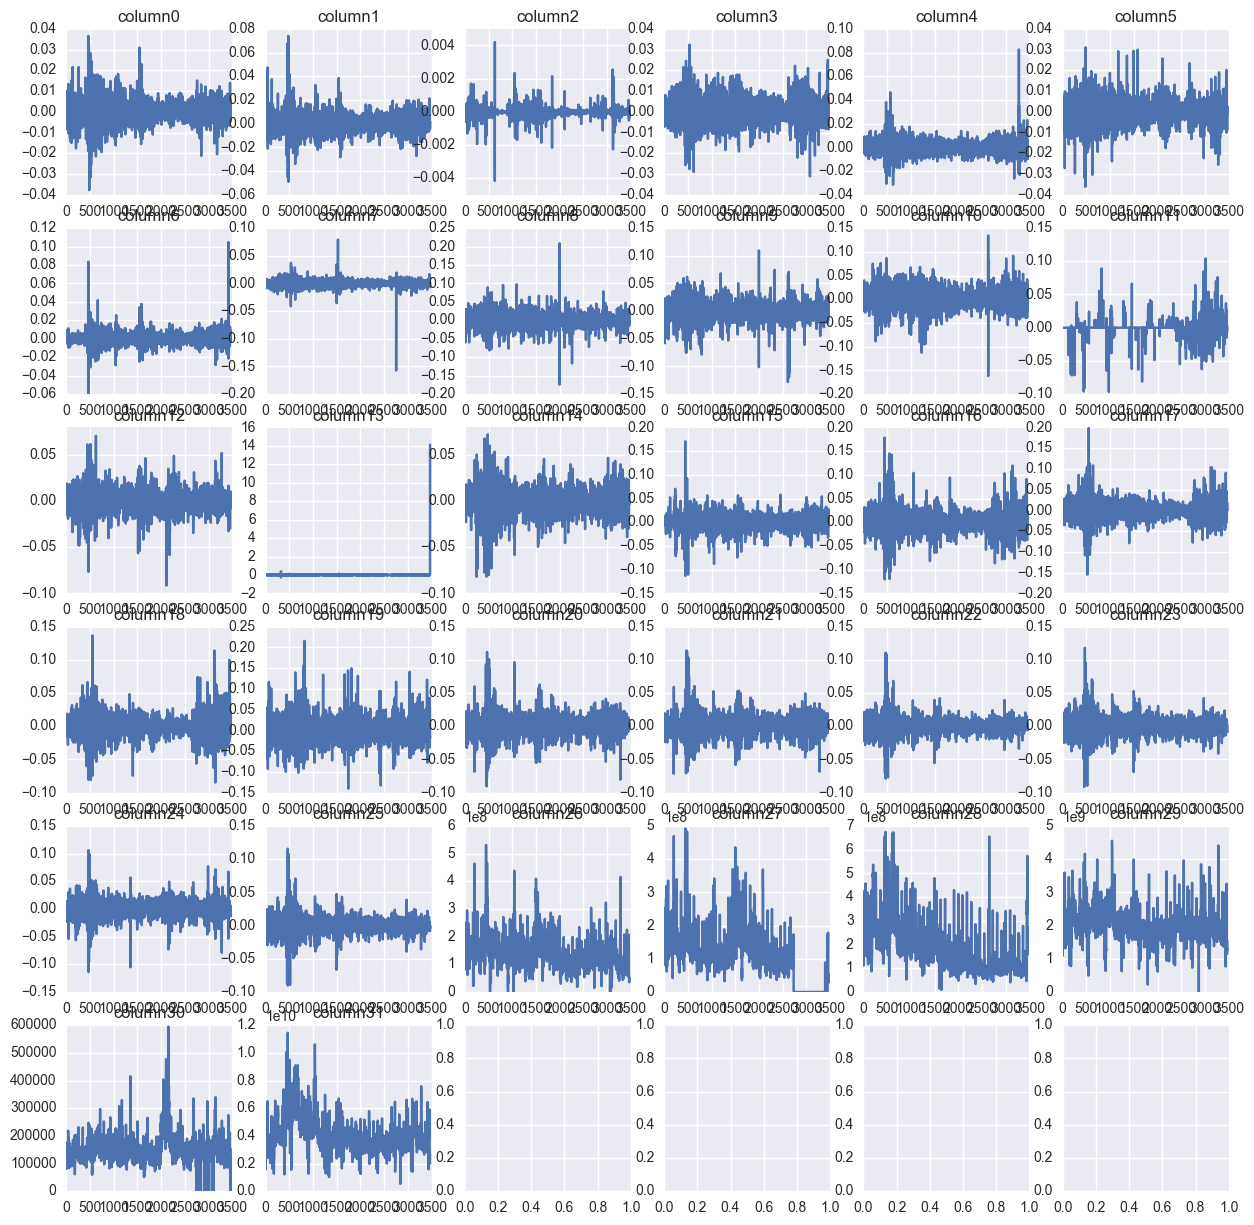

In [17]:
fig, axes = plt.subplots(6, 6, figsize=(15,15))
for i in range(6):
    for j in range(6):
        if (6*i+j > 31):
            pass
        else:
            axes[i, j].plot(temp[:, (6*i+j)])
            axes[i, j].set_title("column" + str(6*i+j))
plt.show()

### Seperation into $y$ and $x$ Matrices

Now, we can finally split the matrix into $x$ predictor matrix and $y$ target matrix. In fact, to be more precise, we cannot use today's returns in our features to predict today's returns in the fx. Hence, we need to match date index $i$ in $x$ with date index $i+1$ of $y$.

In [18]:
y = temp[1:, :8]
x = temp[:-1, 8:]

Now, the columns in y become
0. CAD returns
1. AUD returns
2. HKD returns
3. EUR returns
4. GBP returns
5. JPY returns
6. MXN returns
7. CHF returns

The columns in x become
0. TFGRAIN/CORN.1 returns
1. TFGRAIN/SOYBEANS.1 returns
2. CHRIS/ICE_SB1.1 returns
3. COM/MILK returns
4. COM/AU_EIB returns
5. COM/AG_EIB returns
6. COM/PL_EIB returns
7. COM/PA_EFP returns
8. EIA/PET_RWTC_D returns
9. EIA/PET_RBRTE_D returns
10. OPEC/ORB returns
11. CHRIS/CME_NG1.1 returns
12. cac_40_Adj Close returns
13. dax_Adj Close returns
14. dow_jones_Adj Close returns
15. nasdaq_Adj Close returns
16. nikkei_225_Adj Close returns
17. s&p_500_Adj Close returns
18. cac_40_Volume
19. dax_Volume
20. dow_jones_Volume
21. nasdaq_Volume
22. nikkei_225_Volume
23. s&p_500_Volume

## Rolling Window Transformation

The rolling analysis is preferred because it allows us to use past-T days data on a moving window to predict the value for the next time period.

We define the rolling_window function for further use:

In [19]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### Moving Window = 5

We fit the past 5 days data of all the above 24 features as `training features`.

In [20]:
WINDOW = 5
x_transformed = np.empty(shape=(x.shape[0] - WINDOW + 1,0))
for i in range(x.shape[1]):
    x_transformed = np.concatenate((x_transformed, 
                                    rolling_window(x[:,i], WINDOW)), 
                                   axis=1)

Since we have to use the past (WINDOW=5) days data, our $y$ should be transformed into a matrix that starts (WINDOW=5) - 1 days later.

In [21]:
y_transformed = y[WINDOW-1:]

## Splitting the Data into Train and Test

In machine learning, it is important to test the fitted learning model to judge its predicting abilities. In most machine learning cases, the data is randomly split into the train and test sets. However, in real world finance, since each data entry stemmed from a particular time, combining with the fact that __one cannot use the future to predict the past__, we split the matrix x in this manner 

__1st 2000 days for trainng and the remaining days for backtesting__

In [22]:
x_train = x_transformed[:2000]
y_train = y_transformed[:2000]
x_test = x_transformed[2000:]
y_test = y_transformed[2000:]

# Machine Learning

For the sake of this presentation, we will choose to predict the USD/JPY currency pair.

In [23]:
jpy_train = y_train[:, 5]
jpy_test = y_test[:, 5]

## Linear Regression

We chose a simple supervised learning algorithm - Linear Regression - to predict the direction of the currency pair.

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, jpy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Backtesting Strategy

Backtest strategy by paper trading the currency pair. If predicted returns is negative, we take a short position, else we go long. Suppose we start with $1 in our portfolio. 

From the pnl graph, the meaningful observation should be the outsample pnl (the right side of the red line). Hence, this learning algorithm clearly does not work for trading as we do not see any gain nor loss in money after holding for 1500 trading days, let alone the transaction costs.

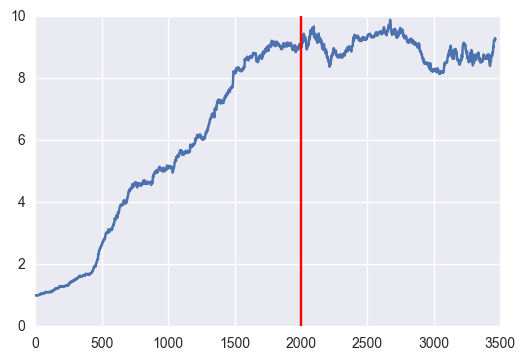

In [43]:
jpy_insample = lr.predict(x_train)
jpy_outsample = lr.predict(x_test)
strat_insample = np.where(jpy_insample<0, -1, 1)
strat_outsample = np.where(jpy_outsample<0, -1, 1)
pnl = np.cumprod(np.concatenate((strat_insample*jpy_train, strat_outsample*jpy_test)) + 1)
plt.plot(pnl)
plt.axvline(x=2000, color='r', linestyle='-')
plt.show()